# SediNet: compute grain size

Demonstration of SediNet using [Panel](https://panel.pyviz.org/index.html)

In [1]:
from file_select import FileBrowser
from PIL import Image
import random

In [2]:
import sys
#sys.path.append('../')
from sedinet_models import *
import panel as pn
pn.extension()
#import ipywidgets as widgets

Using TensorFlow backend.


In [3]:
configfile = 'config_9percentiles.json'

In [15]:
import json
# load the user configs
with open('config'+os.sep+configfile) as f:    
  config = json.load(f) 

###===================================================
## user defined variables: proportion of data to use for training (a.k.a. the "train/test split")
base    = int(config["base"]) #minimum number of convolutions in a sedinet convolutional block
csvfile = config["csvfile"] #csvfile containing image names and class values
res_folder = config["res_folder"] #folder containing csv file and that will contain model outputs
name = config["name"] #name prefix for output files
dropout = float(config["dropout"]) 
add_bn = bool(config["add_bn"]) 

vars = [k for k in config.keys() if not np.any([k.startswith('base'), k.startswith('res_folder'), k.startswith('csvfile'), k.startswith('name'), k.startswith('dropout'), k.startswith('add_bn')])]

vars = sorted(vars)

###==================================================

csvfile = os.path.abspath(os.getcwd()+os.sep+res_folder+os.sep+csvfile)

In [16]:
## read the data set in, clean and modify the pathnames so they are absolute
df = pd.read_csv(csvfile)
#df.head()

files          P5         P10         P16         P25  \
0    images/0017_cu_2.jpg  157.531008  163.524318  193.523998  242.937372   
1   images/0024_makro.JPG   28.491462   29.090640   93.344704   99.606606   
2   images/0026_makro.jpg   96.598080  112.946434  130.520800  150.386110   
3   images/0028_makro.JPG   14.403512   32.439962   77.355830   81.716607   
4  images/0029_1_Bali.JPG   85.291010  101.428090  115.873130  133.550600   

          P50         P75         P84         P90         P95  
0  306.646585  400.529437  542.478336  590.942023  679.817999  
1  152.296404  192.930107  224.613440  257.227486  266.258329  
2  174.783480  200.456530  227.279650  257.470400  318.274260  
3   91.060446  138.156058  140.699858  153.670320  207.444480  
4  154.489330  178.496600  203.890400  232.938190  285.091920

In [17]:
df['files'] = [k.strip() for k in df['files']]
df['files'] = [os.getcwd()+os.sep+f.replace('\\',os.sep) for f in df['files']]  

In [18]:
models = []
for base in [base-2,base,base+2]:
  weights_path = name+"_base"+str(base)+"_model_checkpoint.hdf5"
  ##==============================================
  ## create a SediNet model to estimate sediment category
  model = make_cont_sedinet(base, vars, add_bn, dropout)
  model.load_weights(os.getcwd()+os.sep+'res'+os.sep+res_folder+os.sep+weights_path)
  models.append(model)

[INFORMATION] Model summary:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 512, 1024, 1) 0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 510, 1022, 14 140         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 508, 1020, 28 3556        conv2d_9[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 254, 510, 28) 0           conv2d_10[0][0]                  
________________________________________________________________________________

[INFORMATION] Model summary:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 512, 1024, 1) 0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 510, 1022, 18 180         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 508, 1020, 36 5868        conv2d_17[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 254, 510, 36) 0           conv2d_18[0][0]                  
________________________________________________________________________________

In [19]:
def get_image():
    #get a random image
    n = random.choice((67364561,67447491,67449081,59858041,94974311,65614911))
    img = 'https://www.allaboutbirds.org/guide/assets/photo/{n}-1280px.jpg'.format(n=n)
    return img

def get_grainsize():
    
    im = Image.open(file_input.value).convert('LA')
    im = im.resize((IM_HEIGHT, IM_HEIGHT))
    im = np.array(im) / 255.0    
    im2 = np.rot90(im)         
    im = np.expand_dims(np.hstack((im[:,:,0], im2[:,:,0])),axis=2) 
    im = np.expand_dims(im, axis=0)

    for v in vars:
      exec(v+'_PT = []')
     
    for model in models:   
      tmp = model.predict(im, batch_size=1)
      exec(vars[0]+'_PT.append(np.asarray(np.squeeze(tmp)))') #.argmax(axis=-1))')

    exec(vars[0]+'_predT = np.squeeze(np.mean(np.asarray('+vars[0]+'_PT), axis=0))')

    Text.object = 'Grain size: '+str(eval(vars[0]+'_predT'))+' microns'
    return Text, Text2

def get_plot():
    im = Image.open(file_input.value)#.convert('LA')
    im = np.array(im) / 255.0    
    plot = plt.imshow(im)
    return plot

def show_message():
    Text2.object = 'Calculated grain size for '+file_input.value +'.....'
    return Text2

def update(event):
    Text2 = show_message()
    jpg_panel.object = file_input.value 
    Text = get_grainsize()
    
##=====    
title = pn.pane.HTML('<h2> SediNet: compute sieve size</h2>')

imfile = 'MardaScience_logo_circle.JPG'
#setup the logo pane
logo = pn.pane.JPG(get_image(), width=100)
logo.object = imfile

update_btn = pn.widgets.Button(name='Calculate Grain Size!',width=100,button_type='primary')
s = pn.pane.HTML('<h5>Compute equivalent sieve diameters directly from an image, without the need for area-to-mass conversion formulas and without even knowing the scale of one pixel. This demonstration has been implemented using a a small population of beach sands</h5>')
file_input = pn.widgets.FileInput()
file_input = pn.widgets.Select(name='Select an image file:', options=list(df.files.values))

Text = pn.panel('Grain size:', width=200, height=60)

Text2 = pn.panel('', width=200, height=60)
    
#setup the jpg pane
jpg_panel = pn.pane.JPG(get_image(), width=300)
jpg_panel.object = file_input.value 

footer = pn.pane.HTML('<h6>Demonstration of SediNet using Panel. Written by Daniel Buscombe, MARDA Science</h6>')

#watch associates a button click with the update function
update_btn.param.watch(update, 'clicks')
#add the widgets to panes
top = pn.Row(file_input) 
mid = pn.Row(update_btn)

app = pn.Column(title, logo, s, top,mid,jpg_panel, Text2, Text,footer)
app.show()

W0921 19:45:22.220031 12764 web.py:2246] 404 GET /favicon.ico (::1) 1.01ms


Column
    [0] HTML(str)
    [1] JPG(str, width=100)
    [2] HTML(str)
    [3] Row
        [0] Select(options=['C:\\Users\\ddb265\\SediN...], value='C:\\Users\\ddb265\\SediNe...)
    [4] Row
        [0] Button(button_type='primary', clicks=6, name='Calculate Grain Size!', width=100)
    [5] JPG(str, width=300)
    [6] Markdown(str, height=60, sizing_mode='fixed', width=200)
    [7] Markdown(str, height=60, sizing_mode='fixed', width=200)
    [8] HTML(str)
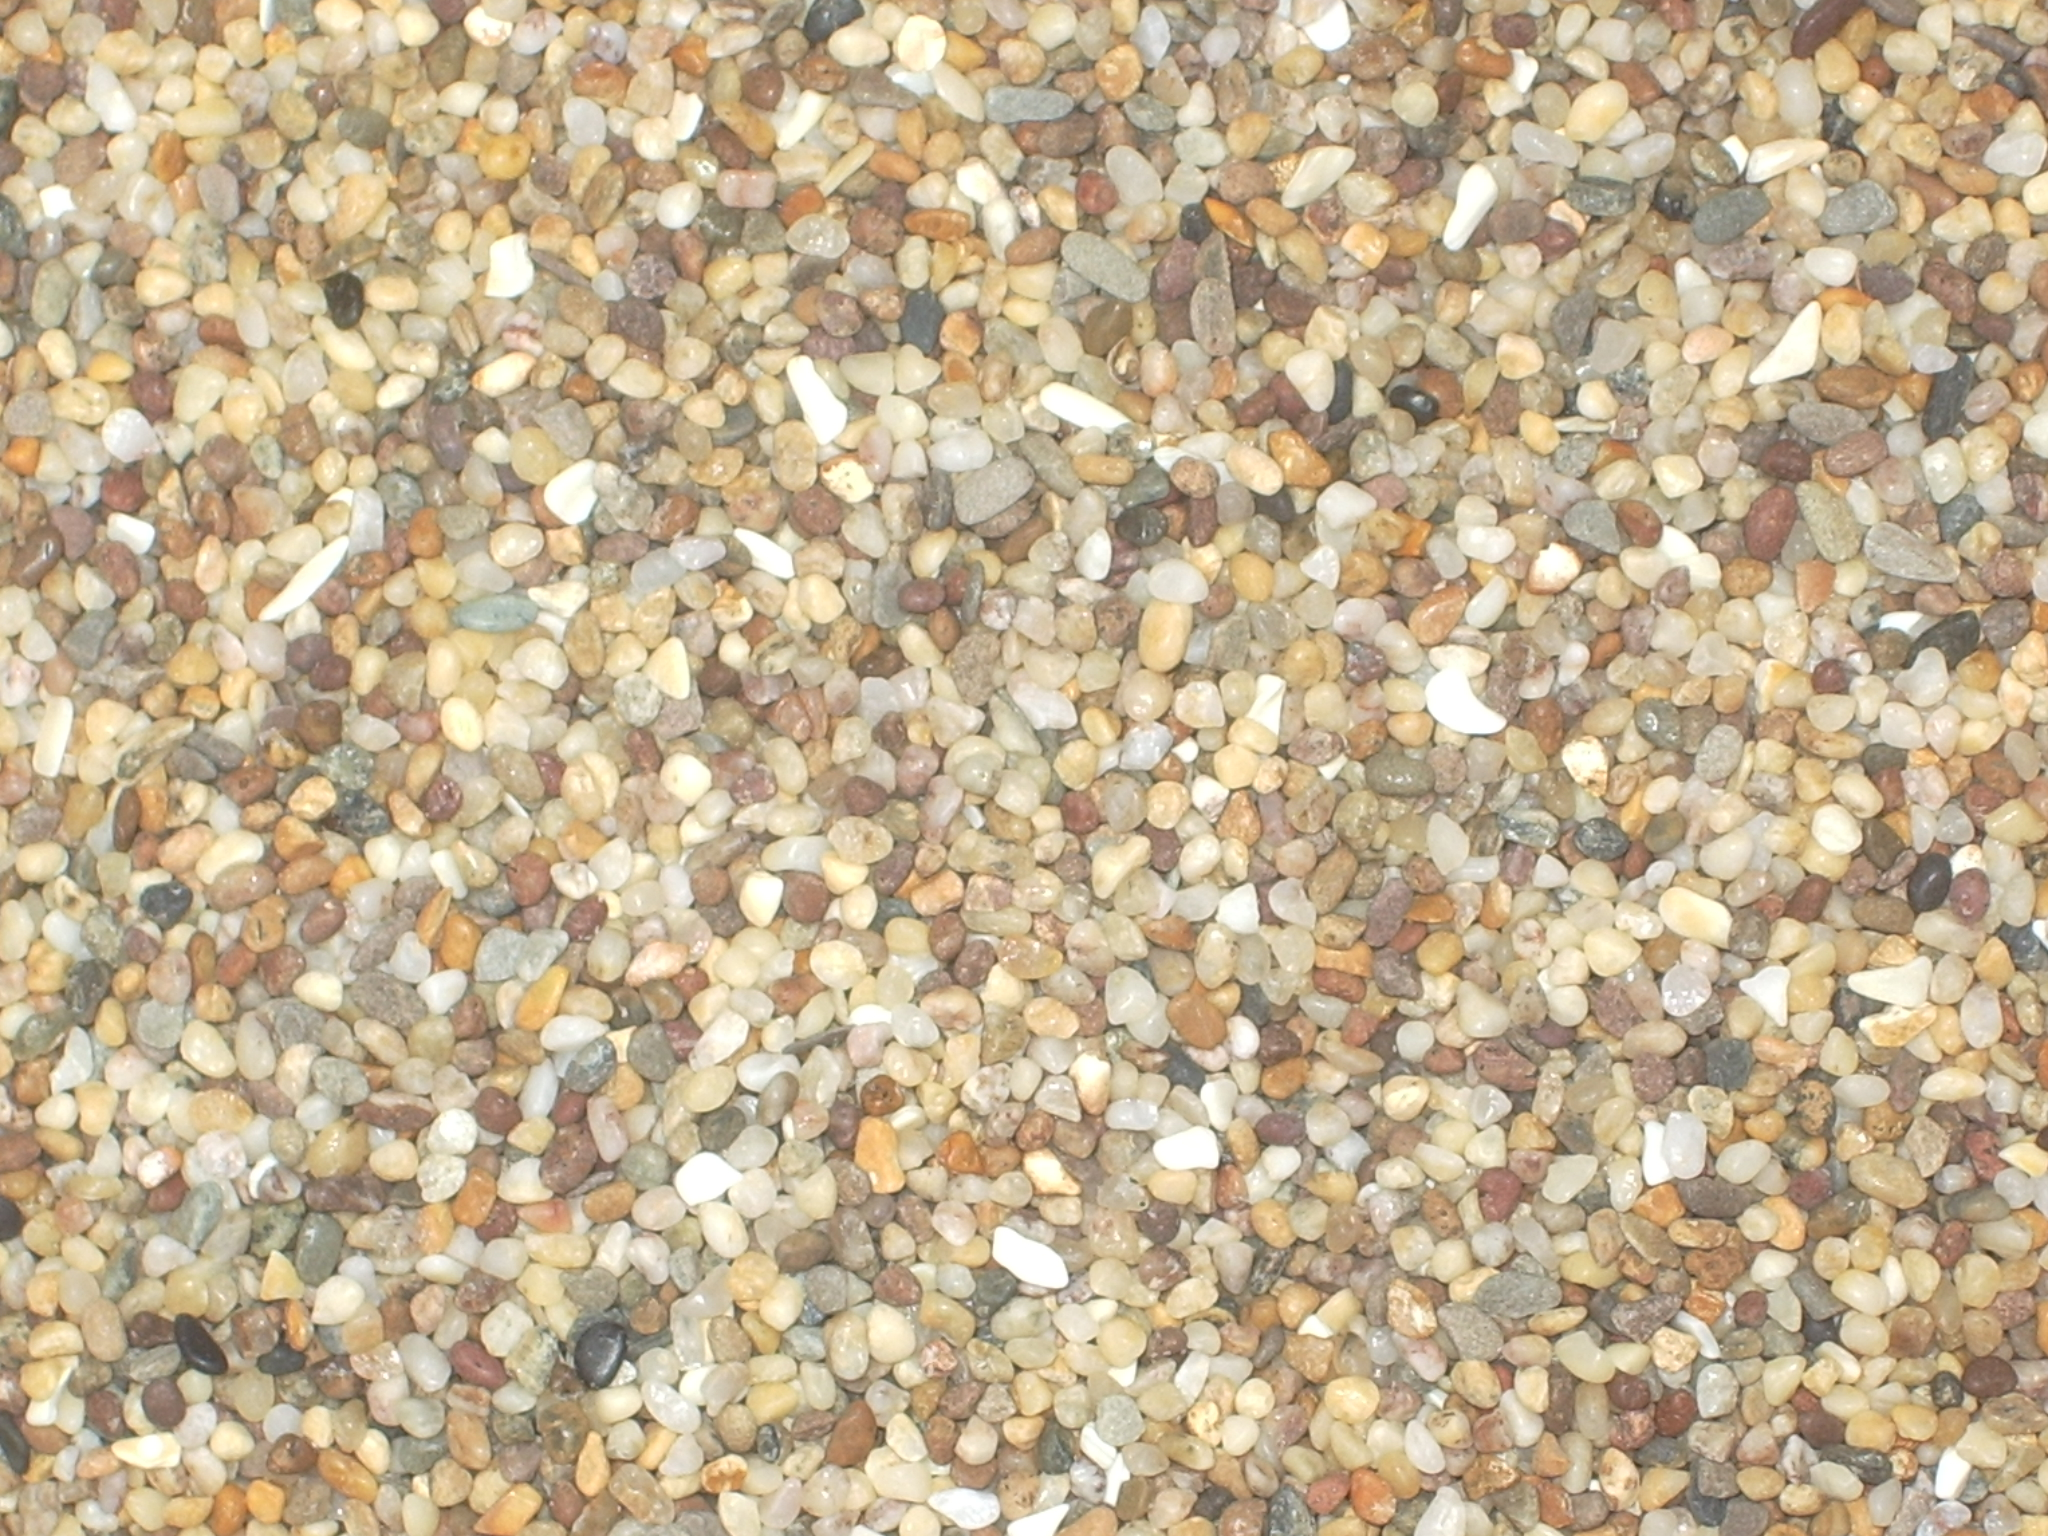
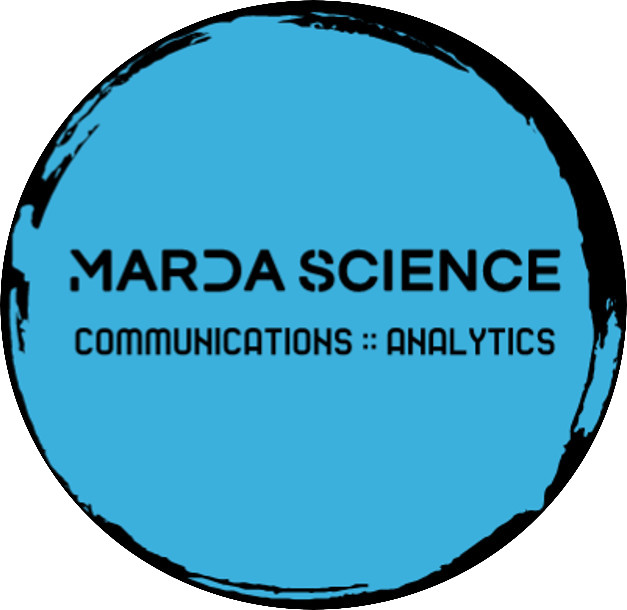

In [13]:
#app